### Data Generator

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import joblib

In [2]:
# Load a sample dataset (you can replace this with your own)
df = pd.read_csv("student_habits_performance.csv")
df_columns = df.columns.tolist()
#df = df[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']].dropna()
df = df[df_columns].dropna()
synthetic_row_count = 1000


In [3]:
# Automatically identify categorical and numerical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df.select_dtypes(include=['number']).columns.tolist()

### Preprocess data (encode categoricals, scale numericals)

In [4]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
])

X_processed = preprocessor.fit_transform(df)
input_dim = X_processed.shape[1]

# Save transformers for inverse transform later
encoder = preprocessor
joblib.dump(encoder, 'vae_preprocessor.joblib')

['vae_preprocessor.joblib']

In [6]:
# Define VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU()
        )
        self.mu = nn.Linear(32, latent_dim)
        self.logvar = nn.Linear(32, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32), nn.ReLU(),
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [7]:
# VAE loss function with beta for KL annealing
def vae_loss(x, x_recon, mu, logvar, beta):
    recon_loss = nn.MSELoss()(x_recon, x)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + beta * kl_div

In [8]:
# Prepare DataLoader
X_tensor = torch.tensor(X_processed, dtype=torch.float32)
dataloader = DataLoader(TensorDataset(X_tensor), batch_size=64, shuffle=True)

In [9]:
# Train VAE with Sigmoid KL annealing and loss tracking
vae = VAE(input_dim=input_dim)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
num_epochs = 100
losses = []

for epoch in range(num_epochs):
    # Sigmoid annealing schedule
    beta = float(1 / (1 + np.exp(-0.2 * (epoch - num_epochs / 2))))
    for batch in dataloader:
        x_batch = batch[0]
        x_recon, mu, logvar = vae(x_batch)
        loss = vae_loss(x_batch, x_recon, mu, logvar, beta)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Beta: {beta:.4f}")

Epoch 1, Loss: 0.0204, Beta: 0.0000
Epoch 2, Loss: 0.0169, Beta: 0.0001
Epoch 3, Loss: 0.0165, Beta: 0.0001
Epoch 4, Loss: 0.0174, Beta: 0.0001
Epoch 5, Loss: 0.0133, Beta: 0.0001
Epoch 6, Loss: 0.0154, Beta: 0.0001
Epoch 7, Loss: 0.0153, Beta: 0.0002
Epoch 8, Loss: 0.0151, Beta: 0.0002
Epoch 9, Loss: 0.0141, Beta: 0.0002
Epoch 10, Loss: 0.0136, Beta: 0.0003
Epoch 11, Loss: 0.0158, Beta: 0.0003
Epoch 12, Loss: 0.0151, Beta: 0.0004
Epoch 13, Loss: 0.0148, Beta: 0.0005
Epoch 14, Loss: 0.0137, Beta: 0.0006
Epoch 15, Loss: 0.0169, Beta: 0.0007
Epoch 16, Loss: 0.0132, Beta: 0.0009
Epoch 17, Loss: 0.0142, Beta: 0.0011
Epoch 18, Loss: 0.0158, Beta: 0.0014
Epoch 19, Loss: 0.0154, Beta: 0.0017
Epoch 20, Loss: 0.0132, Beta: 0.0020
Epoch 21, Loss: 0.0143, Beta: 0.0025
Epoch 22, Loss: 0.0142, Beta: 0.0030
Epoch 23, Loss: 0.0163, Beta: 0.0037
Epoch 24, Loss: 0.0148, Beta: 0.0045
Epoch 25, Loss: 0.0154, Beta: 0.0055
Epoch 26, Loss: 0.0153, Beta: 0.0067
Epoch 27, Loss: 0.0129, Beta: 0.0082
Epoch 28, 

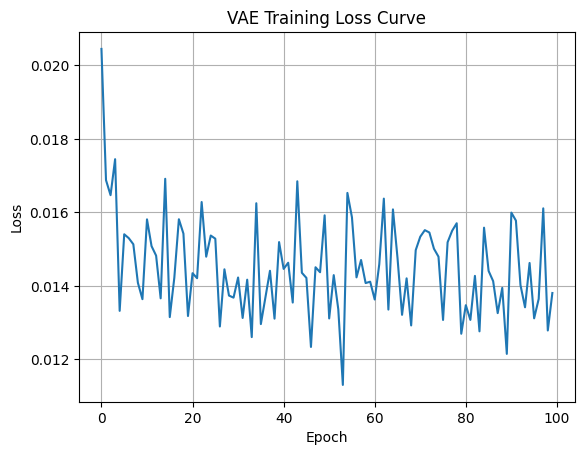

In [10]:
# Plot loss curve
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss Curve")
plt.grid(True)
plt.show()

In [11]:
# Save trained VAE model
torch.save(vae.state_dict(), "vae_model.pth")
print("Trained VAE model saved to 'vae_model.pth'")

Trained VAE model saved to 'vae_model.pth'


In [12]:
# Generate synthetic samples
synthetic_row_count = 100  # You can change this value as needed
with torch.no_grad():
    z = torch.randn(synthetic_row_count, 10)
    synthetic = vae.decoder(z).numpy()

In [14]:
# Inverse transform synthetic data
synthetic_df = pd.DataFrame(encoder.named_transformers_['num'].inverse_transform(
    synthetic[:, :len(num_cols)]), columns=num_cols)

cat_array = encoder.named_transformers_['cat'].inverse_transform(
    synthetic[:, len(num_cols):])

#cat_df = pd.DataFrame(cat_array, columns=encoder.named_transformers_['cat'].get_feature_names_out(cat_cols))
cat_df = pd.DataFrame(cat_array, columns=cat_cols)

final_df = pd.concat([synthetic_df, cat_df], axis=1)

# Save synthetic data
final_df.to_csv("synthetic_data.csv", index=False)
print("Synthetic data saved to 'synthetic_data.csv'")

Synthetic data saved to 'synthetic_data.csv'


In [30]:
# Optional: Round numeric columns if needed
#synthetic_df['Age'] = synthetic_df['Age'].clip(lower=0).round(0)  # round age to nearest int
#synthetic_df['Fare'] = synthetic_df['Fare'].clip(lower=0).round(2)  # keep 2 decimal places

# Map Category Codes to Labels
#cat_df['Sex'] = cat_df['Sex'].map({0: 'male', 1: 'female'})


### Distribution Comparison

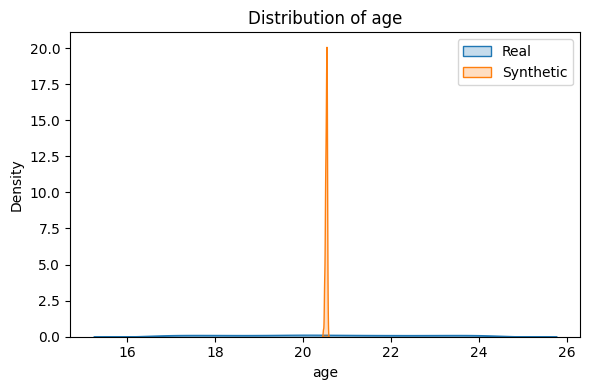

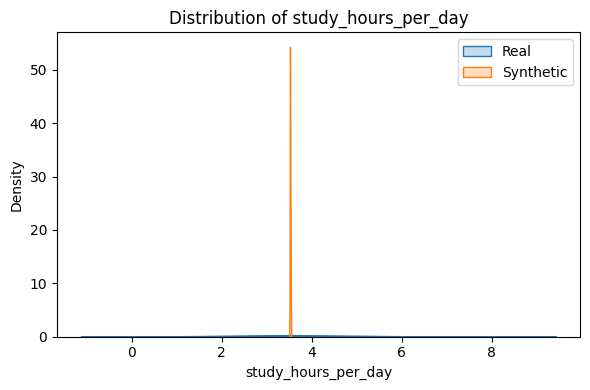

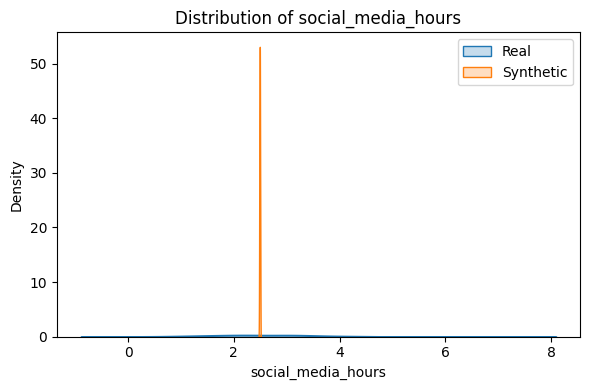

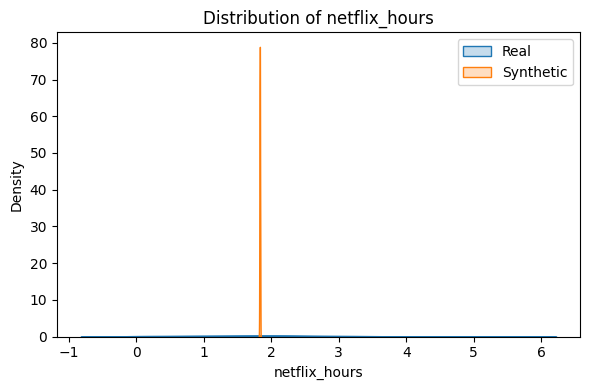

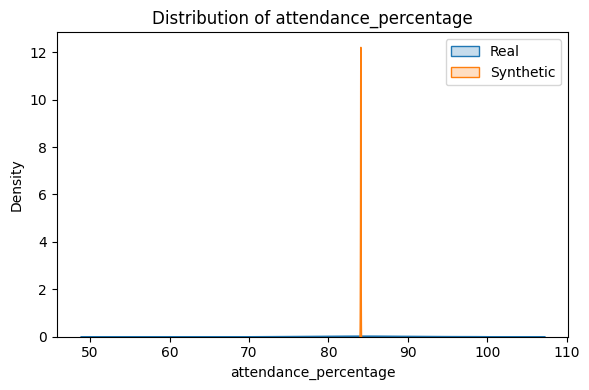

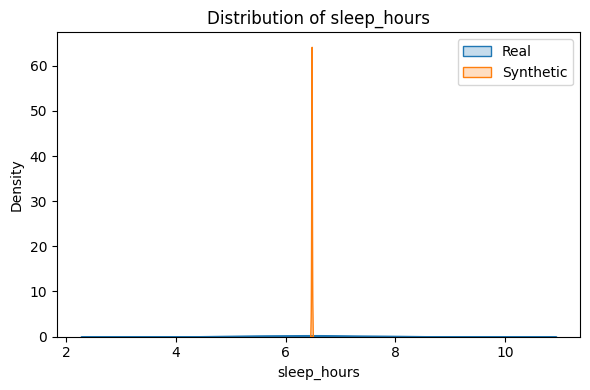

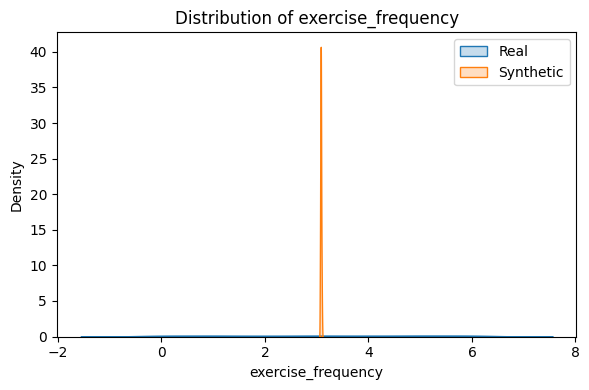

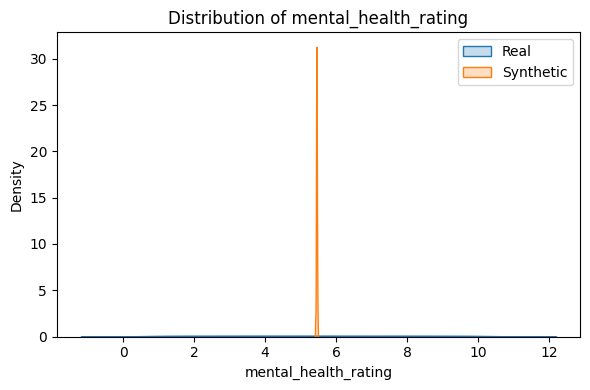

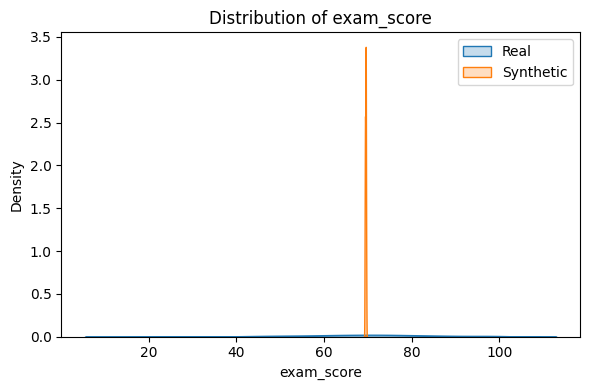

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def compare_distribution(real_df, synth_df, columns):
    for col in columns:
        plt.figure(figsize=(6, 4))
        sns.kdeplot(real_df[col], label='Real', fill=True)
        sns.kdeplot(synth_df[col], label='Synthetic', fill=True)
        plt.title(f'Distribution of {col}')
        plt.legend()
        plt.tight_layout()
        plt.show()

compare_distribution(df[num_cols], synthetic_df, num_cols)


### Categorical Comparison

<Figure size 500x300 with 0 Axes>

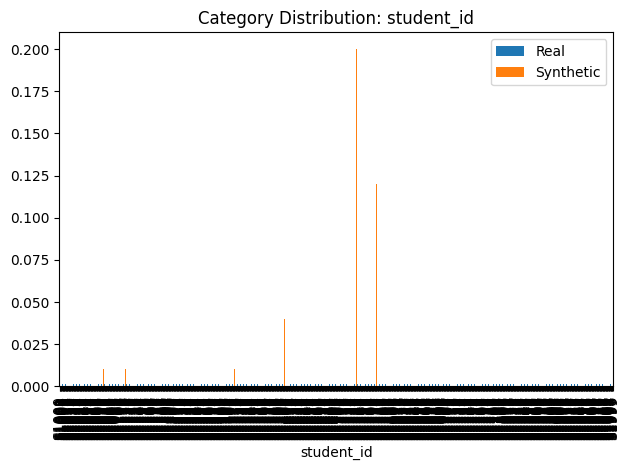

<Figure size 500x300 with 0 Axes>

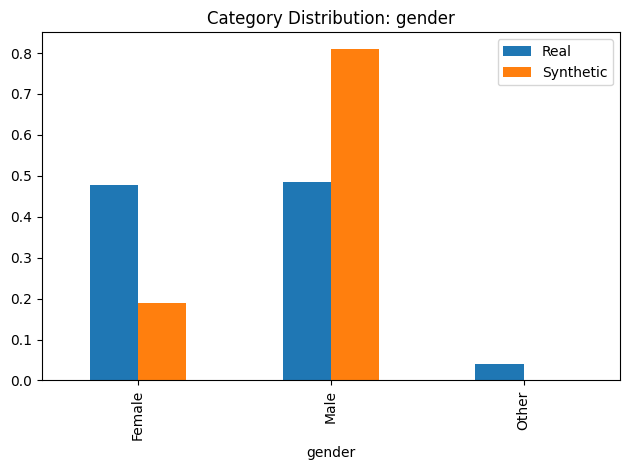

<Figure size 500x300 with 0 Axes>

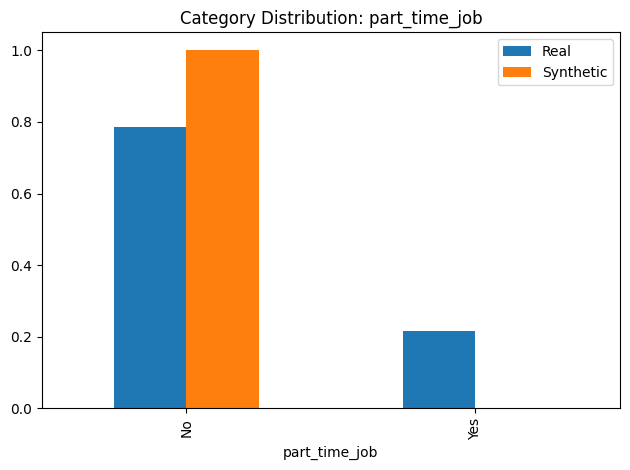

<Figure size 500x300 with 0 Axes>

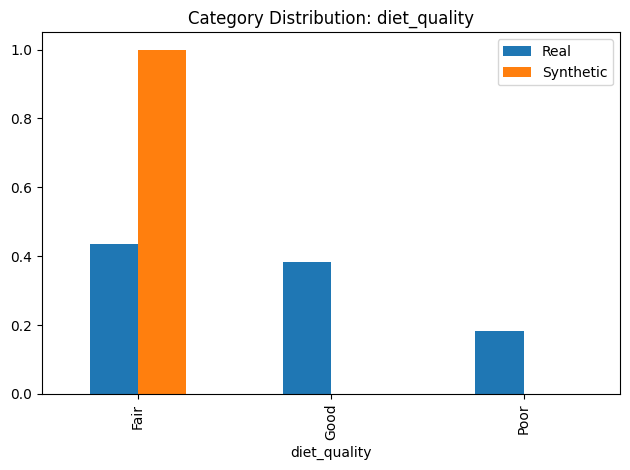

<Figure size 500x300 with 0 Axes>

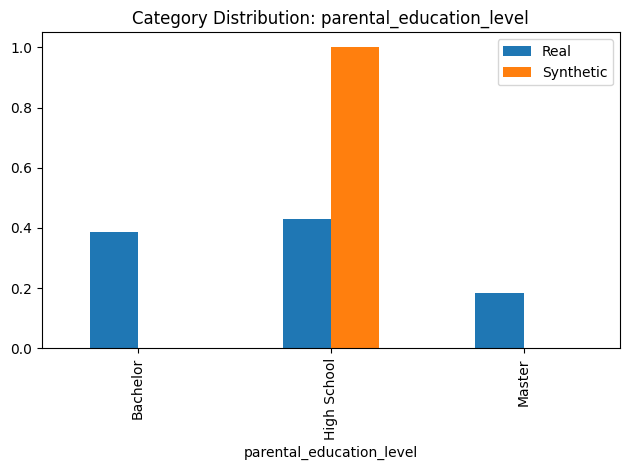

<Figure size 500x300 with 0 Axes>

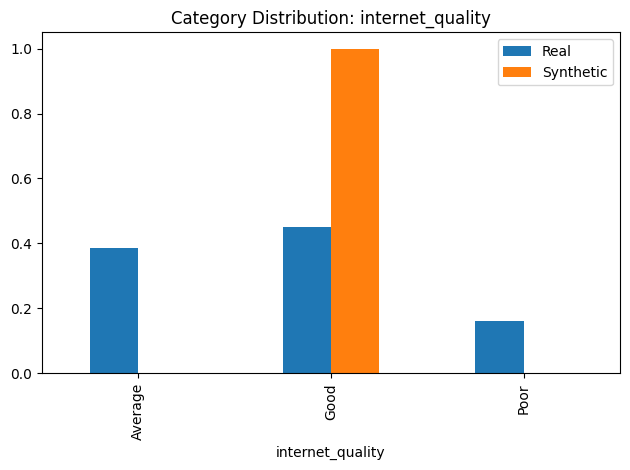

<Figure size 500x300 with 0 Axes>

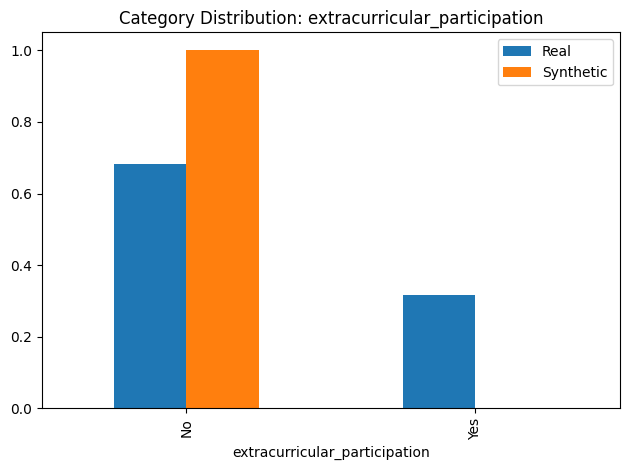

In [16]:
def compare_categorical(real_df, synth_df, columns):
    for col in columns:
        plt.figure(figsize=(5, 3))
        real_counts = real_df[col].value_counts(normalize=True)
        synth_counts = synth_df[col].value_counts(normalize=True)
        comparison = pd.DataFrame({'Real': real_counts, 'Synthetic': synth_counts}).fillna(0)
        comparison.plot(kind='bar')
        plt.title(f'Category Distribution: {col}')
        plt.tight_layout()
        plt.show()

compare_categorical(df, cat_df, cat_cols)